In [1]:
# Import library
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import matplotlib.pyplot as plt # plotting library
import seaborn as sns # visualization library based on matplotlib
from IPython.display import display # Manage multiple output per cell
import datetime

In [2]:
# Define target
target = 'INFO_FTR_H'
start_date = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")

In [3]:
best_features = ['A_MEANS_FIVE_FTHG', 'A_MEANS_FIVE_HS', 'H_MEANS_FIVE_AF',
       'H_MEANS_FIVE_HF', 'A_MEANS_THREE_AF', 'A_MEANS_THREE_HF',
       'A_STD_FIVE_AC', 'A_STD_FIVE_AY', 'DNN_adam_bf', 'DNN_sgd_all',
       'DNN_sgd_bf', 'XGBoost_all', 'SVM', 'RF_all', 'RF_bf', 'NB',
       'MLP', 'LDA', 'KNN', 'ExraTree', 'Bagging_min_sample_all',
       'Bagging_min_sample_bf', 'GB']

In [4]:
# Import dataset
# normal
#train_df = pd.DataFrame.from_csv('./report/layer2-train-INFO_FTR_H-2017-07-08-19-28.csv')
#test_df = pd.DataFrame.from_csv('./report/layer2-test-INFO_FTR_H-2017-07-08-19-28.csv')
# isotonic
#train_df = pd.DataFrame.from_csv('./report/layer2-train-INFO_FTR_H-2017-07-10-10-32.csv')
#test_df = pd.DataFrame.from_csv('./report/layer2-test-INFO_FTR_H-2017-07-10-10-32.csv')
# sigmoid
#train_df = pd.DataFrame.from_csv('./report/layer2-train-INFO_FTR_H-2017-07-10-12-44.csv')
#test_df = pd.DataFrame.from_csv('./report/layer2-test-INFO_FTR_H-2017-07-10-12-44.csv')
# calibrated TODO: Change after applying sigmoid to DNN_adam_all instead of no
train_df = pd.DataFrame.from_csv('./report/layer2-train-INFO_FTR_H-2017-07-10-15-56.csv')
test_df = pd.DataFrame.from_csv('./report/layer2-test-INFO_FTR_H-2017-07-10-15-56.csv')

In [5]:
X_train_df =  train_df.drop(target, 1)
X_test_df = test_df.drop(target, 1)
y_train_df = train_df[target].astype('bool_')
y_test_df= test_df[target].astype('bool_')

In [6]:
# from xgboost import XGBClassifier
# import xgboost as xgb
# # Find the best n_estimator
# import xgboost as xgb
# xgb1 = XGBClassifier(
#  learning_rate =0.01,
#  n_estimators=1000,
#  max_depth=3,
#  min_child_weight=5,
#  gamma=0,
#  subsample=0.8,
#  colsample_bytree=0.8,
#  objective= 'binary:logistic',
#  nthread=4,
#  scale_pos_weight=1,
#  seed=27)
# xgtrain = xgb.DMatrix(X_train_df, label=y_train_df)
# cvresult = xgb.cv(xgb1.get_xgb_params(), xgtrain, num_boost_round=1000, nfold=8,
#             metrics='logloss', early_stopping_rounds=50, verbose_eval=True)
# cvresult.shape[0]
# Result 0.1 = 28
# Result 0.01 = 283

In [7]:
# Import model
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
classifier = XGBClassifier(nthread=4, seed=15)

/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
# Applying Grid Search to find the best hyper-parameters for our Model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.classification import log_loss
from sklearn.metrics import make_scorer
import time

start = time.time()

parameters = [{
    'learning_rate': [0.01],
    'n_estimators': [283],
    'max_depth': [1, 3, 5, 10],
    'min_child_weight': [1, 3, 5, 8],
    'gamma': [0],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'objective': ['binary:logistic'],
    'scale_pos_weight': [1]
}]
parameters = [{
    'learning_rate': [0.01],
    'n_estimators': [283],
    'max_depth': [5],
    'min_child_weight': [1],
    'gamma': [0],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'objective': ['binary:logistic'],
    'scale_pos_weight': [1]
}]
# 'max_depth': 1,'min_child_weight': 1
grid_search = GridSearchCV(estimator=classifier,
                           param_grid=parameters,
                           #scoring=make_scorer(log_loss, greater_is_better=False),
                           scoring='roc_auc',
                           cv=8,
                           n_jobs=-1,
                           verbose=1)
grid_search.fit(X_train_df, y_train_df)

time.time() - start

Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  1.3min finished


86.39317488670349

In [9]:
# Extract best score calculated with the GridSearchCV
best_score = grid_search.best_score_
display(best_score)

0.65115759726225564

In [10]:
# Extract best hyper-parameter calculated with the GridSearchCV
best_params = grid_search.best_params_
best_params

{'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.01,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 283,
 'objective': 'binary:logistic',
 'scale_pos_weight': 1,
 'subsample': 0.8}

In [11]:
# Get all results of Grid Search
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.to_csv('./tuning/layer2-XGBoost-'+start_date+'.csv')
cv_results

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,...,split5_test_score,split5_train_score,split6_test_score,split6_train_score,split7_test_score,split7_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,37.214934,0.070422,0.651158,0.767088,0.8,0,0.01,5,1,283,...,0.646757,0.768852,0.638069,0.766969,0.663606,0.766739,0.349662,0.023595,0.012435,0.00138


# TEST

In [12]:
# Train a new classifier using the best parameters found by the grid search
clf = XGBClassifier(
    nthread=4, 
    seed=15,
    learning_rate=best_params['learning_rate'],
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_child_weight=best_params['min_child_weight'],
    gamma=best_params['gamma'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    objective=best_params['objective'],
    scale_pos_weight=best_params['scale_pos_weight']
)
clf.fit(X_train_df, y_train_df, eval_metric='logloss')

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=283, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=15, silent=True, subsample=0.8)

In [13]:
# Predict target values
y_pred = clf.predict(X_test_df)

In [14]:
# Predict probabilities
y_probs = clf.predict_proba(X_test_df)

In [15]:
# Compute cross-entropy score
from sklearn.metrics import log_loss
log_loss(y_test_df, y_pred)

13.601076539903367

In [16]:
# Compute precision, recall, F-measure and support
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test_df, y_pred, average='binary')

(0.58709338929695698, 0.4545085296506905, 0.51236263736263732, None)

In [17]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test_df, y_pred)

0.59372864555150751

In [18]:
# Compute the confusion Matrix
df_confusion = pd.crosstab(y_test_df, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Predicted,False,True,All
Actual,,,
False,2160,787,2947
True,1343,1119,2462
All,3503,1906,5409


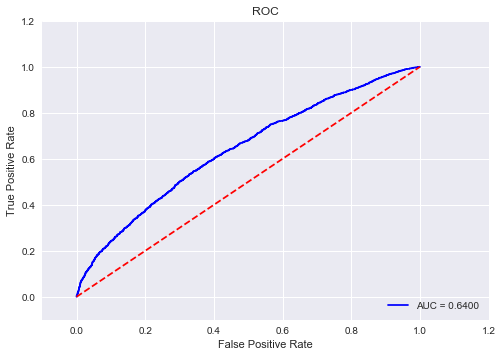

In [19]:
# Plot a ROC curve
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_df, y_probs[:, 1].ravel())
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Feature Importance

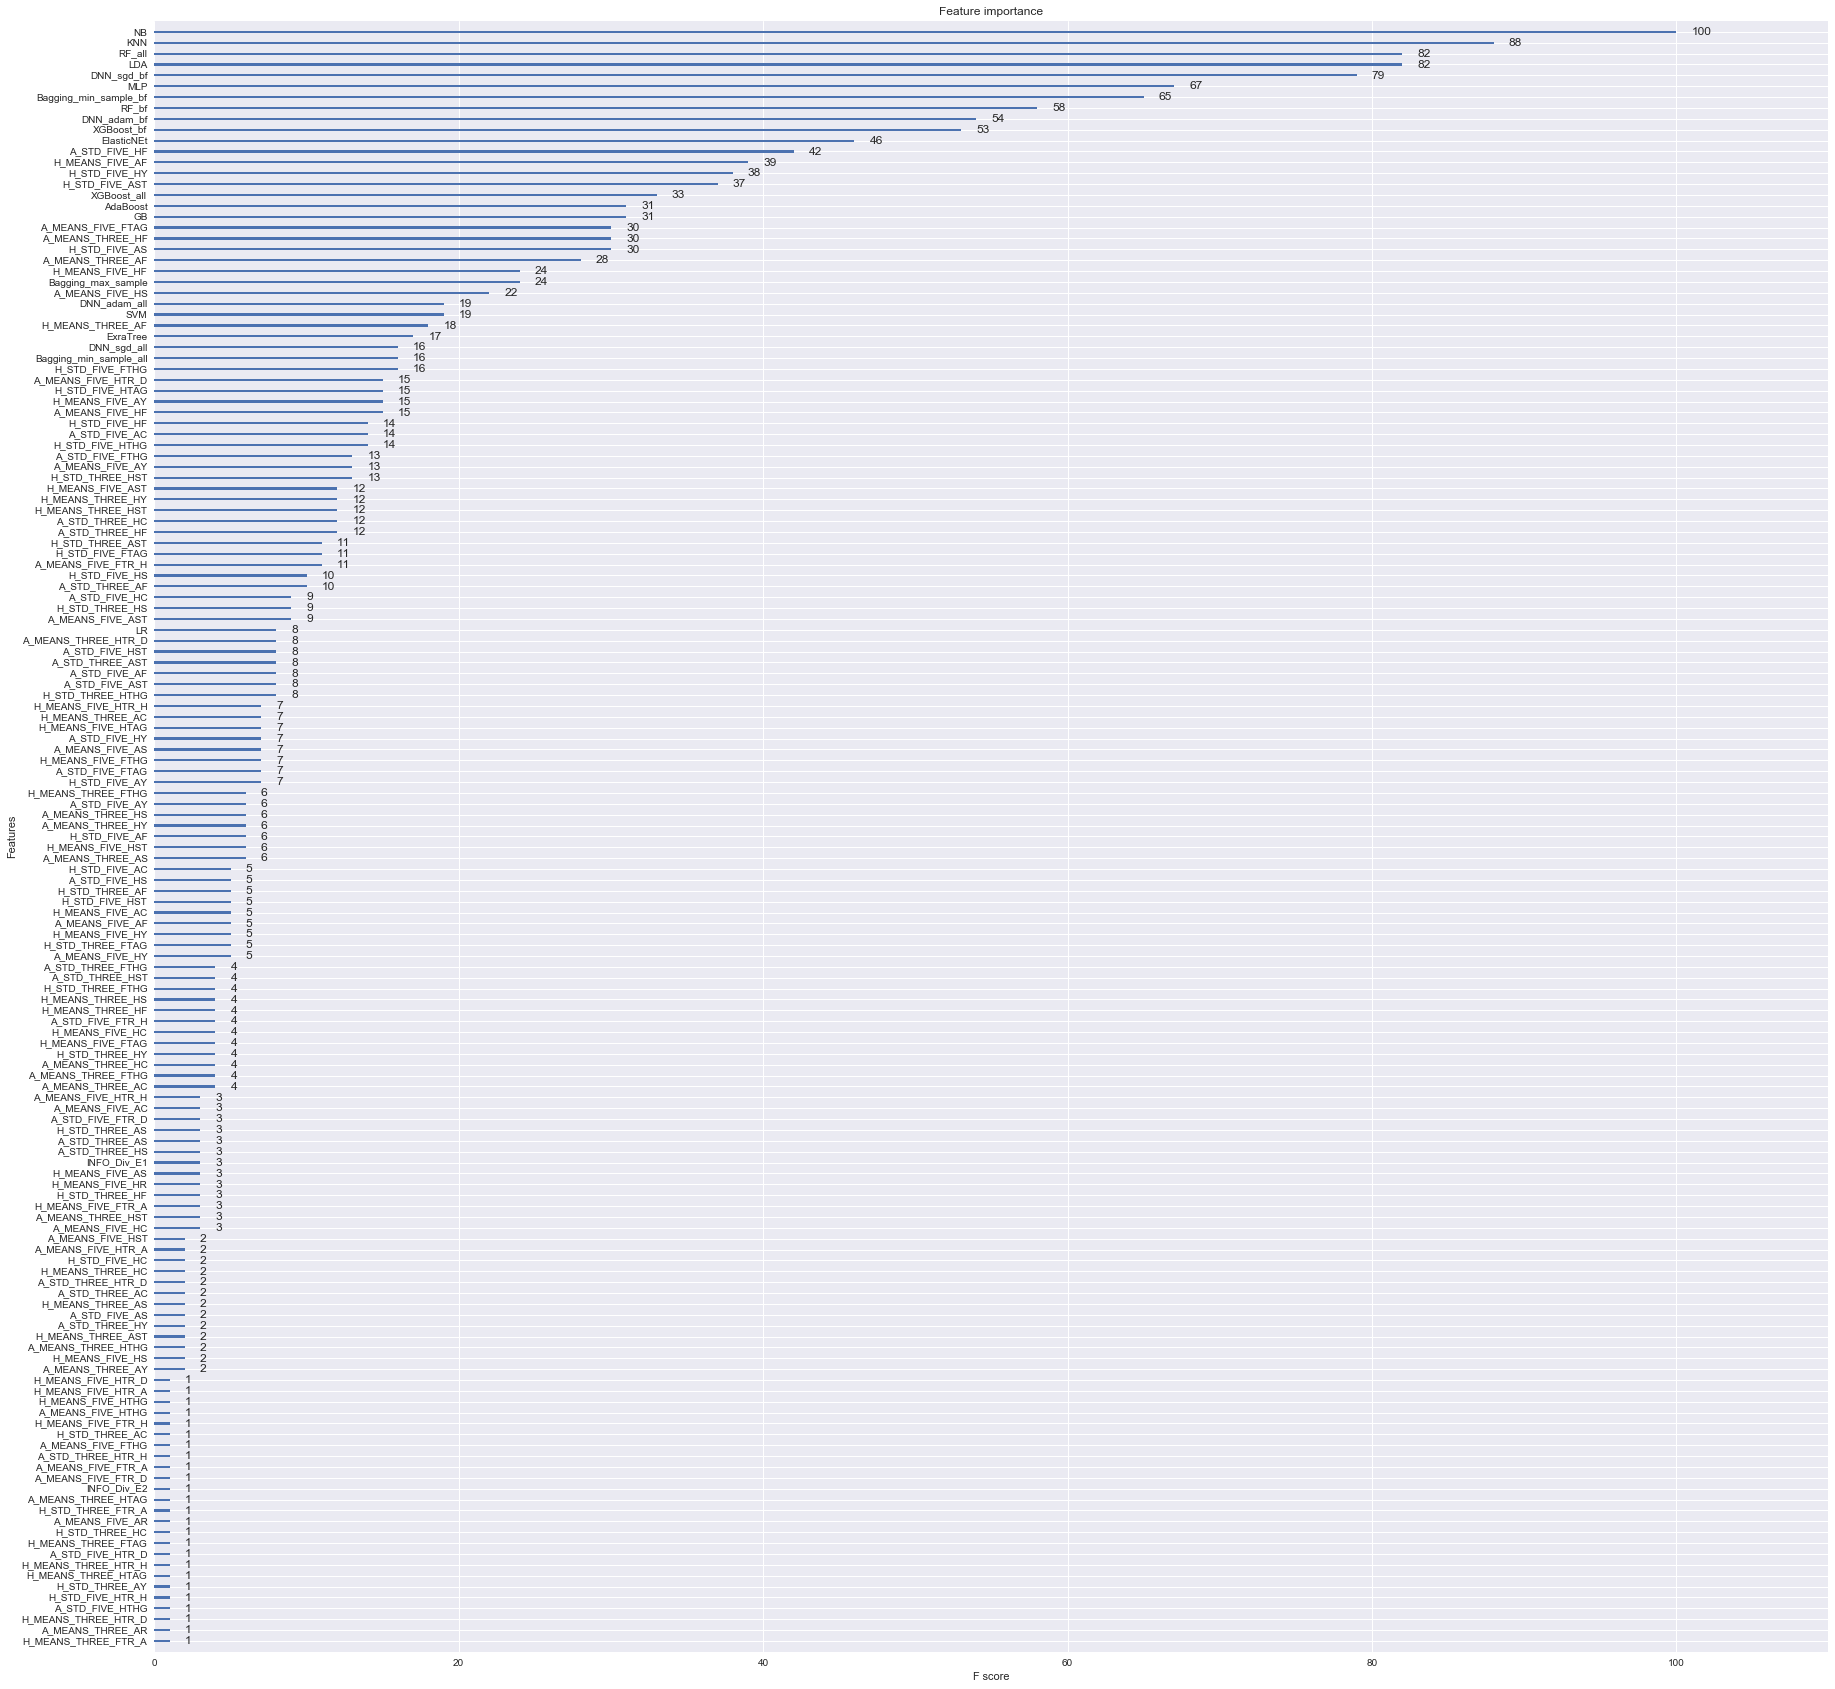

In [20]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
# fit model no training data
model = XGBClassifier(
 learning_rate =0.01,
 n_estimators=283,
 max_depth=3,
 min_child_weight=5,
 gamma=0,
 subsample=0.9,
 colsample_bytree=0.9,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=0)
model.fit(X_train_df, y_train_df, eval_metric='logloss')
# plot feature importance
fig, ax = plt.subplots(figsize=(30,30))
plot_importance(model, ax=ax)
pyplot.show()

In [25]:
# Fit model using each importance as a threshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.calibration import CalibratedClassifierCV
from numpy import sort
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics.classification import log_loss
from sklearn.metrics import make_scorer
seed=15
thresholds = np.unique(sort(model.feature_importances_))
df_fs = pd.DataFrame(columns=('Thresh', 'n', 'll_mean', 'll_std'))
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train_df)
    # define model
    #selection_model = RandomForestClassifier(random_state=0, n_jobs=-1,criterion='entropy', max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=360)
    selection_model = LogisticRegression(random_state=0,n_jobs=-1)
    #selection_model = GaussianNB()
    #selection_model = MLPClassifier(random_state=0,activation='identity', alpha=3, hidden_layer_sizes=(10,), max_iter=200, solver= 'adam')
    #selection_model= SVC(random_state=0,C=0.02,kernel='linear',gamma=1,probability=True)
    #selection_model = CalibratedClassifierCV(ExtraTreesClassifier(random_state=0,n_jobs=-1,criterion='entropy',max_depth=30,max_features=None,min_samples_leaf=1,min_samples_split=16,n_estimators=350), cv=4, method='isotonic')
    # eval model
    logloss = cross_val_score(selection_model, select_X_train, y_train_df, cv=8, scoring='neg_log_loss', n_jobs=-1)
    ll_mean = logloss.mean()
    ll_std = logloss.std()
    df2 = pd.DataFrame([[thresh, select_X_train.shape[1], ll_mean, ll_std]], columns=('Thresh', 'n', 'll_mean', 'll_std'))
    df_fs = df_fs.append(df2)
    print("Thresh=%.5f, n=%d, AUC mean: %.5f, AUC std: %.5f" % (thresh, select_X_train.shape[1], ll_mean, ll_std))
df_fs.to_csv('./feature_selection/'+start_date+'-layer2-Feature_selection.csv')

/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_

Thresh=0.00000, n=205, AUC mean: -0.65207, AUC std: 0.00855


/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


KeyboardInterrupt: 

In [22]:
from sklearn.feature_selection import SelectFromModel
import numpy as np
np.set_printoptions(threshold=np.nan)
selection = SelectFromModel(model, threshold=0.0, prefit=True)
feature_idx = selection.get_support()
feature_name = pd.get_dummies(X_train_df).columns[feature_idx]
feature_name

Index([u'A_MEANS_FIVE_AC', u'A_MEANS_FIVE_AF', u'A_MEANS_FIVE_AR',
       u'A_MEANS_FIVE_AS', u'A_MEANS_FIVE_AST', u'A_MEANS_FIVE_AY',
       u'A_MEANS_FIVE_FTAG', u'A_MEANS_FIVE_FTHG', u'A_MEANS_FIVE_FTR_A',
       u'A_MEANS_FIVE_FTR_D',
       ...
       u'LDA', u'KNN', u'ExraTree', u'ElasticNEt', u'Bagging_max_sample',
       u'Bagging_min_sample_all', u'Bagging_min_sample_bf', u'AdaBoost', u'GB',
       u'LR'],
      dtype='object', length=205)

In [23]:
# BEST ARE:
# Logsitic Regression: Thresh=0.00154, n=111, AUC mean: 0.65870, AUC std: 0.01013
# Naive Bayes: Thresh=0.00768, n=36, AUC mean: 0.65462, AUC std: 0.01036
# MLP: Thresh=0.02971, n=8, AUC mean: 0.65596, AUC std: 0.01026
# Extra Tree: Thresh=0.00922, n=28, AUC mean: 0.65177, AUC std: 0.01343

In [24]:
for feature in feature_name:
    print "'"+feature+"',"

'A_MEANS_FIVE_AC',
'A_MEANS_FIVE_AF',
'A_MEANS_FIVE_AR',
'A_MEANS_FIVE_AS',
'A_MEANS_FIVE_AST',
'A_MEANS_FIVE_AY',
'A_MEANS_FIVE_FTAG',
'A_MEANS_FIVE_FTHG',
'A_MEANS_FIVE_FTR_A',
'A_MEANS_FIVE_FTR_D',
'A_MEANS_FIVE_FTR_H',
'A_MEANS_FIVE_HC',
'A_MEANS_FIVE_HF',
'A_MEANS_FIVE_HR',
'A_MEANS_FIVE_HS',
'A_MEANS_FIVE_HST',
'A_MEANS_FIVE_HTAG',
'A_MEANS_FIVE_HTHG',
'A_MEANS_FIVE_HTR_A',
'A_MEANS_FIVE_HTR_D',
'A_MEANS_FIVE_HTR_H',
'A_MEANS_FIVE_HY',
'H_MEANS_FIVE_AC',
'H_MEANS_FIVE_AF',
'H_MEANS_FIVE_AR',
'H_MEANS_FIVE_AS',
'H_MEANS_FIVE_AST',
'H_MEANS_FIVE_AY',
'H_MEANS_FIVE_FTAG',
'H_MEANS_FIVE_FTHG',
'H_MEANS_FIVE_FTR_A',
'H_MEANS_FIVE_FTR_D',
'H_MEANS_FIVE_FTR_H',
'H_MEANS_FIVE_HC',
'H_MEANS_FIVE_HF',
'H_MEANS_FIVE_HR',
'H_MEANS_FIVE_HS',
'H_MEANS_FIVE_HST',
'H_MEANS_FIVE_HTAG',
'H_MEANS_FIVE_HTHG',
'H_MEANS_FIVE_HTR_A',
'H_MEANS_FIVE_HTR_D',
'H_MEANS_FIVE_HTR_H',
'H_MEANS_FIVE_HY',
'A_MEANS_THREE_AC',
'A_MEANS_THREE_AF',
'A_MEANS_THREE_AR',
'A_MEANS_THREE_AS',
'A_MEANS_THREE_AST',
'A_MEAN